<div style="float: block; text-align: center; line-height: 1.7em">
    <span style="font-size: 2em; font-weight: bold"> Fatigue-Sleepiness in Irregular Workloads for Pilots </span><br>
    <span style="font-size: 1.5em"> Exploratory Data Analysis </span><br>
</div>

---

# 1. Loading Required Libraries and Data

In [1]:
import os as os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1.1. Loading data

In [2]:
file = os.path.join('data/processed_features.csv')
df = pd.read_csv(file)
df.head(5)

,Id,kss,sps,quest_fill_hour,workload_moment,workload_type,workload_type_prev_es,workload_type_prev_nt,workload_length,sleep_duration,...,Num_Sons,Flight_hours,Education,Marital_status,Time_displacement,Age,Classification,Disturbed_sleep,Awakening,Sleep_Fatig
0,P01,5,4.0,AFT,start,others,0,0,8.883333,8.383333,...,2,17000.0,PHD,MARRIED,60,49,INT,13,9,14
1,P01,5,5.0,EVE,middle,others,0,0,8.900000,8.383333,...,2,17000.0,PHD,MARRIED,60,49,INT,13,9,14
2,P01,7,6.0,NI,end,others,0,0,8.916667,8.383333,...,2,17000.0,PHD,MARRIED,60,49,INT,13,9,14
3,P01,7,5.0,NI,start,early-start,0,0,5.450000,7.200000,...,2,17000.0,PHD,MARRIED,60,49,INT,13,9,14
4,P01,4,3.0,MOR,middle,early-start,0,0,5.466667,7.200000,...,2,17000.0,PHD,MARRIED,60,49,INT,13,9,14


---

# 2. Response Variables or Targets

The aim of this work is to quantify sleepiness and fatigue in pilots. So, this problem presents us two response or target variable, Karolinska Sleepiness Scale (kss) and Sam-Perelli fatigue Scale(sps). Both variables are obtained through the use of questionnaries filled in either start, middle and end of workload or duty periods. The tables shown bellow give us what the scales mean.

* **Karolinska Sleepiness Scale (kss)**

| Scale | Original meaning as in google questionnary (Portuguese) | English Translation |
| --- | --- | --- |
| 1 | Muito Alerta | Extremely alert |
| 2 - 3 | Alerta | Alert |
| 4 - 5 | Nem sonolento, nem alerta | Nor sleepy, nor alert |
| 6 - 7 | Sonolento, mas consigo ficar acordado | Drowsy, but I can stay awake |
| 8 - 9 | Muito sonolento, brigando com o sono | Very drowsy, fighting with sleep |

* **Sam-Perelli Fatigue Scale (sps)**

| Scale | Original meaning as in google questionnary (Portuguese) | English Translation |
| --- | --- | --- |
| 1 | Totalmente alerta, bem desperto, extremamente disposto | Fully alert, wide awake, extremely willing |
| 2 | Muito ativo, responsivo, mas não em nível máximo | Very active, responsive, but not at maximum level |
| 3 | Bem, relativamente revigorado | Well, relatively refreshed |
| 4 | Um pouco cansado, não totalmente disposto | A little tired, not quite in the mood |
| 5 | Moderadamente cansado, enfraquecido | Moderately tired, weakened | 
| 6 | Muito cansado, com dificuldade de concentração | Very tired, with difficulty concentrating |
| 7 | Completamente exausto, incapaz de trabalhar efetivamente | Completely exhausted, unable to work effectively |


## 2.2. Experimental Design

Both the sps and kss measurements were taken along three moments of the workloads (start, middle, end and in days-off) and these workloads moments can happen along the some moments along the day (EM, MOR, AFT, EVE, NI). So, the workload are crossed with the moments along the day. Thus, we propose, the following experimental design, depicted bellow:

| | EM | MOR | AFT | EVE | NI |
| --- | -- | --- | --- | --- | --- |
| start | | | | |
| middle | | | | |
| end | | | | |

The measurements were took irregularly, in other words, some participants filled the kss and sps more times than others and not necessarily in consecutive workloads.

However, some measurements, as will be shown bellow, are taken just once per workload, such as variables related to sleep previous workload, time awake before, previous workload modality before the current workload and etc. So, thinking in terms of regression analysis, beyond the dependency of participant, one can think in dependency of the moments along the day as well, acting like a random intercept or even a random slope.

## 2.3. Recategorization of Response Variables

Kss and sps scales consists of integer numbers ranging from 1 to 9 and 1 to 7 respectively, that cannot be taken as a continuous result (but as categorical ordinal). Thinking in terms of modelling it is simpler to reduce this result from 9 or 7 categories to 2 categories. Previous works using the same scales, but for railway workers, use the same approach, due to simplicity, assertiveness and easy interpretation of results.

In this approach we obtain the following:

* **Karolinska scale dichotomized ( Excessive Sleepiness indicator - kssd)**

| Scale Range | Meaning | New Value |
| --- | --- | --- |
| 1 - 6 | Normal | 0 |
| 7 - 9 | Excessive Sleepiness | 1 |

* **Sam-Perelli scale dichotomized (Severe Fatigue indicator - spsd)**

| Scale Range | Meaning | New Value |
| --- | --- | --- |
| 1 - 4 | Normal | 0 |
| 5 - 7 | Severe Fatigue | 1 |



In [3]:
# Applying the rule

df['kssd'] = df['kss'].apply(lambda x: 1 if x >= 7 else 0)
df['spsd'] = df['sps'].apply(lambda x: 1 if x >= 5 else 0)

## 2.4. Getting only working days

The measurements were taken in both workings days and days-off, so the data base were divided to analyze only working days and days off.

In [4]:
working_df = df[df['workload_moment'].isin(['start','middle','end'])]
working_df.head(5)

,Id,kss,sps,quest_fill_hour,workload_moment,workload_type,workload_type_prev_es,workload_type_prev_nt,workload_length,sleep_duration,...,Education,Marital_status,Time_displacement,Age,Classification,Disturbed_sleep,Awakening,Sleep_Fatig,kssd,spsd
0,P01,5,4.0,AFT,start,others,0,0,8.883333,8.383333,...,PHD,MARRIED,60,49,INT,13,9,14,0,0
1,P01,5,5.0,EVE,middle,others,0,0,8.900000,8.383333,...,PHD,MARRIED,60,49,INT,13,9,14,0,1
2,P01,7,6.0,NI,end,others,0,0,8.916667,8.383333,...,PHD,MARRIED,60,49,INT,13,9,14,1,1
3,P01,7,5.0,NI,start,early-start,0,0,5.450000,7.200000,...,PHD,MARRIED,60,49,INT,13,9,14,1,1
4,P01,4,3.0,MOR,middle,early-start,0,0,5.466667,7.200000,...,PHD,MARRIED,60,49,INT,13,9,14,0,0


### 2.4.1. Getting the number of times wherein the kss and sps were filled

In [5]:
print('---------------------------------------------------------------------------------------')
print(f'number of times during working days wherein the kss and sps scales were filled, {len(working_df)}')
print('---------------------------------------------------------------------------------------')

---------------------------------------------------------------------------------------
number of times during working days wherein the kss and sps scales were filled, 1079
---------------------------------------------------------------------------------------


Text(0, 0.5, 'Times wherein filled kss+sps')

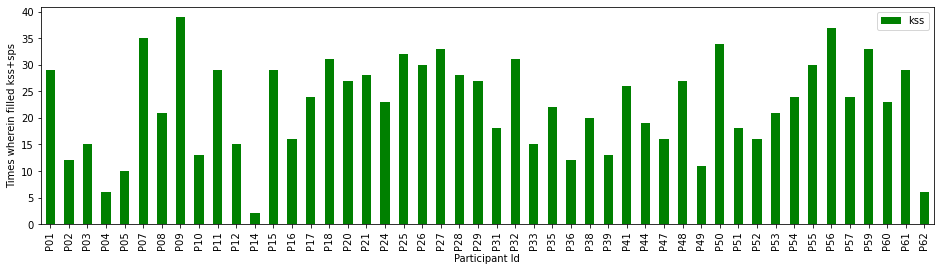

In [35]:
temp = working_df.groupby('Id').agg('count')

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))
temp.plot.bar(y = 'kss', ax = ax, color = 'green')
ax.set_xlabel('Participant Id')
ax.set_ylabel('Times wherein filled kss+sps')

Figure above shows the number of times wherein one participant filled the kss and sps scales. As we can see some participants as "P09' and others as "P14" had different behaviours in filling the scales, evidencing the irregularity of our experimental design.

In face of this result, we will only retain participants that filled the scales at least 10 times

In [72]:
# This dataframe is only composed by the participants Id which filled kss and sps scales more than 10 times.
# to be joined with the final dataframe

selected = pd.DataFrame( temp['kss'].copy().loc[temp.kss > 10].index )
selected['select'] = 1

## 2.5. Occurrences of Excessive Sleepiness and Severe Fatigue

### 2.5.1. Function Display Side-by-side

In [7]:
from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").format(precision=2)\
                          .set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

### 2.5.2. Workload Moment & Filling Time

In [8]:
# Workload Moment
x1 = pd.crosstab(working_df['kssd'], working_df['workload_moment'], rownames=['Sleepiness'], colnames=['Workload'], margins=True, normalize='columns')
x2 = pd.crosstab(working_df['spsd'], working_df['workload_moment'], rownames=['Fatigue'], colnames=['Workload'], margins=True, normalize='columns')

# Display
display_side_by_side( [x1,x2], ['(a) Workload Moment-Excessive Sleepiness', '(b) Workload Moment-Severe Fatigue'] )
print(''); print('')

# filling time
x1 = pd.crosstab(working_df['kssd'], working_df['quest_fill_hour'], rownames=['Sleepiness'], colnames=['Filling Time'], margins=True, normalize='columns')
x2 = pd.crosstab(working_df['spsd'], working_df['quest_fill_hour'], rownames=['Fatigue'], colnames=['Filling Time'], margins=True, normalize='columns')

# Display
display_side_by_side( [x1,x2], ['(c) Filling Time Excessive Sleepiness', '(d) Filling Time Severe Fatigue'] )
print(''); print('')

Workload,end,middle,start,All
Sleepiness,,,,
0,0.66,0.87,0.92,0.81
1,0.34,0.13,0.08,0.19
Workload,end,middle,start,All
Fatigue,,,,
0,0.57,0.83,0.92,0.77
1,0.43,0.17,0.08,0.23


Filling Time,AFT,EM,EVE,MOR,NI,All
Sleepiness,,,,,,
0,0.89,0.84,0.80,0.85,0.67,0.81
1,0.11,0.16,0.20,0.15,0.33,0.19
Filling Time,AFT,EM,EVE,MOR,NI,All
Fatigue,,,,,,
0,0.87,0.83,0.71,0.81,0.63,0.77
1,0.13,0.17,0.29,0.19,0.37,0.23


Contingencies tables between Excessive Sleepiness (a & c) and Severe Fatigue (b & d) with Workload Moment (a & b) and Filling Time (c & d) are shown above in terms of relative frequency. We can see the following patterns:

* Both excessive sleepiness and severe fatigue tend to be more frequently during the end of workload than in the middle or start;

* Both excessive sleepiness and severe fatigue tend to be more frequently during the NI (Night period, between 00:00 and 05:59) period than in oher periods;

* The severity of fatigue and excessiveness of sleepiness rises from start to the end of workload;

### 2.5.3 - Workload Types

In [9]:
# filling time
x1 = pd.crosstab(working_df['kssd'], working_df['workload_type'], rownames=['Sleepiness'], colnames=['workload_type'], margins=True, normalize='columns')
x2 = pd.crosstab(working_df['spsd'], working_df['workload_type'], rownames=['Fatigue'], colnames=['workload_type'], margins=True, normalize='columns')

# Display
print(''); print('')
display_side_by_side( [x1,x2], ['(a) Workload Type Excessive Sleepiness', '(d) Workload Type Severe Fatigue'] )
print(''); print('')

workload_type,early-start,night,others,All
Sleepiness,,,,
0,0.87,0.74,0.86,0.81
1,0.13,0.26,0.14,0.19
workload_type,early-start,night,others,All
Fatigue,,,,
0,0.87,0.68,0.80,0.77
1,0.13,0.32,0.20,0.23


The table above shows contingencies tables between excessive sleepiness (a) and severe fatigue (b) with workload types. The following patterns can be seen:

* Night routines (Workloads comprehending the night period or between 00:00 and 05:59), presents the greater frequency of both, excessive sleepiness and severe fatigue;

* In terms of occurrence of excessiveness of slepiness, no diffeerences is found between early-start and others modalities;

* However, for occurrence of severity of fatigue, early-start (workloads comprehending early-start period or between 06:00 and 07:59) routine have the small relative frequency of occurrence.

### 2.5.4. Previous Workload Types

In [10]:
# filling time
x1 = pd.crosstab(working_df['kssd'], working_df['workload_type_prev_es'], rownames=['Sleepiness'], colnames=['workload_type'], margins=True, normalize='columns')
x2 = pd.crosstab(working_df['spsd'], working_df['workload_type_prev_es'], rownames=['Fatigue'], colnames=['workload_type'], margins=True, normalize='columns')

# Display
print(''); print('')
display_side_by_side( [x1,x2], ['(a) Previous ES Excessive Sleepiness', '(b) Previous ES Type Severe Fatigue'] )
print(''); print('')

# filling time
x1 = pd.crosstab(working_df['kssd'], working_df['workload_type_prev_nt'], rownames=['Sleepiness'], colnames=['workload_type'], margins=True, normalize='columns')
x2 = pd.crosstab(working_df['spsd'], working_df['workload_type_prev_nt'], rownames=['Fatigue'], colnames=['workload_type'], margins=True, normalize='columns')

# Display
display_side_by_side( [x1,x2], ['(c) Previous NT Excessive Sleepiness', '(d) Previous NT Type Severe Fatigue'] )
print(''); print('')

workload_type,0,1,2,3,All
Sleepiness,,,,,
0,0.81,0.80,0.97,0.92,0.81
1,0.19,0.20,0.03,0.08,0.19
workload_type,0,1,2,3,All
Fatigue,,,,,
0,0.76,0.82,0.86,0.92,0.77
1,0.24,0.18,0.14,0.08,0.23


workload_type,0,1,2,All
Sleepiness,,,,
0,0.82,0.78,0.82,0.81
1,0.18,0.22,0.18,0.19
workload_type,0,1,2,All
Fatigue,,,,
0,0.79,0.70,0.76,0.77
1,0.21,0.30,0.24,0.23


* For previous Early-Start modality (a & b) we not found relative frequencies for excessive sleepiness or sever fatigue that are above non previous early-start modality (0);

* For previous Night modality (c & d), we found that for workloads preceded by one previous night (1) workloads the relative frequency of excessive sleepiness and severe fatigue are greater than non previos night modality (0).

# 3. Variables relative to durations

Differently from kss and sps, variables relative to time durations or peridos, were taken just once in a workload period. So, to analyze them, some data manipulation is needed to extract a single value, instead of three as previously.

In [12]:
temp = working_df[['Id', 'sleep_duration', 'time_awake', 'workload_length']].copy().drop_duplicates()
temp.head(5).round(2)

,Id,sleep_duration,time_awake,workload_length
0,P01,8.38,8.47,8.88
1,P01,8.38,8.47,8.90
2,P01,8.38,8.47,8.92
3,P01,7.20,1.90,5.45
4,P01,7.20,1.90,5.47


In [158]:
print('----------------------------------------------------------------')
print(f'Number of workloads: {len(temp)}')
print('----------------------------------------------------------------')

----------------------------------------------------------------
Number of workloads: 432
----------------------------------------------------------------


## 3.1. Distributions of variables relative to duration

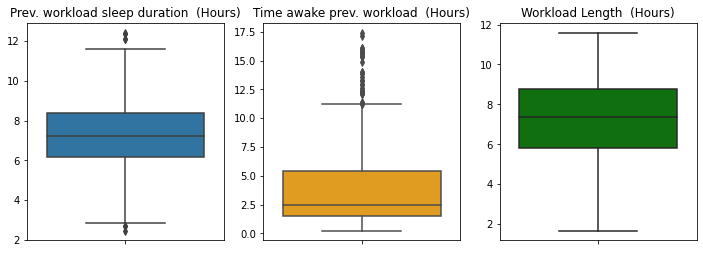

,sleep_duration,time_awake,workload_length
count,431.00,429.00,429.00
mean,7.17,4.05,7.17
std,1.77,3.69,2.38
min,2.47,0.25,1.68
25%,6.17,1.53,5.80
50%,7.20,2.50,7.37
75%,8.38,5.40,8.78
max,12.42,17.40,11.58


In [13]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(12,4))
sns.boxplot(data = temp, y='sleep_duration', ax = ax[0])
ax[0].set_title('Prev. workload sleep duration  (Hours)')
ax[0].set_ylabel('')
sns.boxplot(data = temp, y='time_awake', ax = ax[1], color = 'orange')
ax[1].set_title('Time awake prev. workload  (Hours)')
ax[1].set_ylabel('')
sns.boxplot(data = temp, y='workload_length', ax = ax[2], color = 'green')
ax[2].set_title('Workload Length  (Hours)')
ax[2].set_ylabel('')
plt.show()

temp.describe().round(2)

Resume measurements and boxplots of duration variables are presented above. We can see that the variables sleep duration before workload and workload length, approximately have a symetric behaviour, presenting mean and media near to each other, indicating that:

* The participants in mean sleep about 7 hours before the workload;

* The workload length in mean is about 7 hours.

The variable time awake before the workload has an assimetric behaviour, so the median is more representative of the average participants behaviour than the mean, thus,

* Before the workload, the participants in average were about 2 hours and 30 min awake.

## 3.2. Distribution of Duration Variables with kss (Perception of Sleepiness)

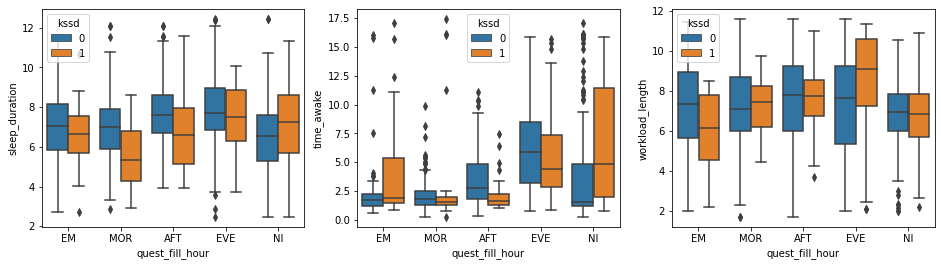

In [14]:
temp = working_df[['kssd','spsd','quest_fill_hour', 'workload_moment', 'sleep_duration', 
                   'time_awake', 'workload_length']].copy()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(16,4))
sns.boxplot(data = temp, x = 'quest_fill_hour', y = 'sleep_duration', hue = 'kssd', order = ['EM','MOR','AFT','EVE','NI'], ax = ax[0])
sns.boxplot(data = temp, x = 'quest_fill_hour', y = 'time_awake', hue = 'kssd', order = ['EM','MOR','AFT','EVE','NI'], ax = ax[1])
sns.boxplot(data = temp, x = 'quest_fill_hour', y = 'workload_length', hue = 'kssd', order = ['EM','MOR','AFT','EVE','NI'], ax = ax[2])
plt.show()

Above is shown boxplots representing the duration variables with perception of sleepiness and the evolution of time discretized. We can conclude that:

* Moring period is associated with less sleep duration previous workload, indicating that pilots who probably start their routine at MOR period, sleep less than in other periods.

* As day evolves from EM to NI, both for excessive and non excessive sleepiness, the time awake before rises, except for the night period (NI), probably due to the wide range (00:00 to 05:59).

* For workload length, routines comprehending periods Early-Morning (or Early-Start) and Night (NI) tend to be shorter, in terms of excessive sleepiness, shorter EM and longer EVE workloads stand-out. 

## 3.3. Distribution of Duration Variables with sps (Perception of fatigue)

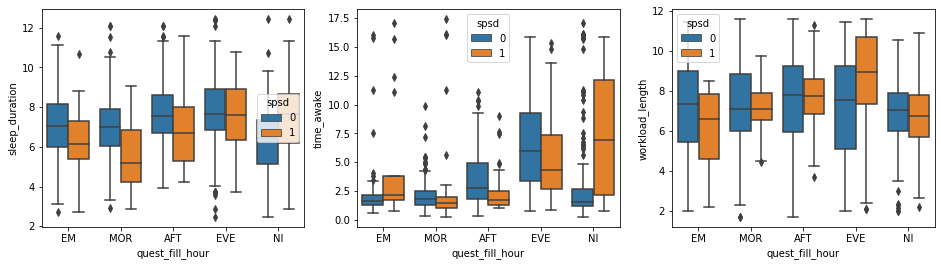

In [15]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(16,4))
sns.boxplot(data = temp, x = 'quest_fill_hour', y = 'sleep_duration', hue = 'spsd', order = ['EM','MOR','AFT','EVE','NI'], ax = ax[0])
sns.boxplot(data = temp, x = 'quest_fill_hour', y = 'time_awake', hue = 'spsd', order = ['EM','MOR','AFT','EVE','NI'], ax = ax[1])
sns.boxplot(data = temp, x = 'quest_fill_hour', y = 'workload_length', hue = 'spsd', order = ['EM','MOR','AFT','EVE','NI'], ax = ax[2])
plt.show()

It is shown above the evolution of sleep duration, time awake before workload and workload length with time for severe and non severe fatigue.

* The same patterns as observed for perception sleepines is found for perception of fatigue.

# 4. Relative to Naps

## 4.1. Number of Naps

In [16]:
x1 = pd.crosstab(working_df['kssd'], working_df['nap_number'], rownames=['Sleepiness'], 
                 colnames=['nap_number'], margins=True, normalize='columns')

x2 = pd.crosstab(working_df['spsd'], working_df['nap_number'], rownames=['Fatigue'], 
                 colnames=['nap_number'], margins=True, normalize='columns')

print(''); print('')
display_side_by_side( [x1,x2], ['(a) # Naps During Workload - Excessive Sleepiness', '(b) # Naps During Workload - Severe Fatigue'] )
print(''); print('')

nap_number,0,1,2,All
Sleepiness,,,,
0,0.85,0.73,0.79,0.81
1,0.15,0.27,0.21,0.19
nap_number,0,1,2,All
Fatigue,,,,
0,0.80,0.71,0.66,0.77
1,0.20,0.29,0.34,0.23


* The relative frequency for excessive sleepiness for pilots who took at least 1 nap is greater than for whom didn't take. This can indicate that as drowsy is the pilot during its workload or duty period more prone is he/she to take a nap.

* For severe fatigue, we found a pattern of raise in relative frequencies as the number of naps raise, this indicates that as fatigated is the pilot during its workload or duty period more prone is he/she to take a nap.

* **To study the effectiveness of naps during workloads, we need to observe the kss and sps before and after the nap**

# 5. Sociodemographic Variables

In [17]:
temp = working_df[['Id','Sex','Position','Num_Sons','Education','Marital_status','Time_displacement', 'Flight_hours', 'Age']].copy().drop_duplicates()
temp['Flight_hours'] = temp['Flight_hours']/1000             # each 1k hour
temp['Time_displacement'] = temp['Time_displacement']/60     # each 1 hour
temp.head(5).round(2)

,Id,Sex,Position,Num_Sons,Education,Marital_status,Time_displacement,Flight_hours,Age
0,P01,MALE,CMTE,2,PHD,MARRIED,1.00,17.0,49
43,P02,MALE,CMTE,2,ESPEC,MARRIED,0.33,17.0,57
78,P03,MALE,CMTE,1,ESPEC,NON_STABLE,7.00,8.0,42
114,P04,MALE,CMTE,0,ESPEC,MARRIED,0.33,5.2,34
124,P05,MALE,COPIL,0,UNIV_INC,DIVORCED,0.50,11.0,41


## 5.1. Continuous variables

In [18]:
temp[['Time_displacement', 'Flight_hours', 'Age']].describe().round(2)

,Time_displacement,Flight_hours,Age
count,48.00,47.00,48.00
mean,1.96,8.08,40.56
std,1.78,5.89,10.21
min,0.17,1.50,25.00
25%,0.50,3.50,32.00
50%,1.04,6.50,39.50
75%,3.50,11.50,48.25
max,7.00,29.00,66.00


* Resume measurements for flight hours and time displacement is shown above. As we can see both the variables are assimetric toward low values, presenting the median less than the mean, with the median of about 6.5k and 1 hours respectively.

## 5.2. Categorical features

In [19]:
x1 = temp['Sex'].value_counts().to_frame()
x2 = temp['Position'].value_counts().to_frame()
x3 = temp['Education'].value_counts().to_frame()
x4 = temp['Marital_status'].value_counts().to_frame()
x5 = temp['Num_Sons'].astype(str).value_counts().to_frame()

print(''); print('')
display_side_by_side( [x1,x2,x3,x4,x5], ['(a)', '(b)', '(c)', '(d)', '(e)'] )
print(''); print('')

,Sex
MALE,41
FEMALE,7
,Position
CMTE,25
COPIL,23
,Education
UNIV_COMP,21
ESPEC,16
UNIV_INC,6
ENS_MED_COMP,3


A summary for categorical sociodemographic variables is shown above. Some variables can be recategorized, such as:

* Education into High (higher education) and N_High (non-higher education),so categories such as UNIV_COMP, ESPEC, PHD and ME categorized into High and ENS_MED_COMP, UNIV_INC into N_High.

* Marital Status in to Married and single, where MARRIED, STABLE_UNION into Married and SINGLE, NON_STABLE and DIVORCED into Single.

## 5.3. Description of an Average Participant

The sample is composed of 48 participants, where 41 are males and 7 females, 25 commanders and 23 co-pilots. Their mean age are around 40 years old and they have around 6500 hours of flight, 39 of them have higher education and 29 of them are married or in stable unions. 27 of them have at least one children and the average time from home to work is 6:30 hours. 

# 6. Other Variables

In [20]:
temp = working_df[['Id','Classification','Disturbed_sleep','Awakening','Sleep_Fatig']].copy().drop_duplicates()
temp.head(5)

,Id,Classification,Disturbed_sleep,Awakening,Sleep_Fatig
0,P01,INT,13,9,14
43,P02,INT,6,3,25
78,P03,MAT,11,7,10
114,P04,INT,11,9,12
124,P05,VES,18,11,18


## 6.1. Chronotype

In [21]:
temp['Classification'].value_counts().to_frame()

,Classification
INT,24
MAT,16
VES,8


Above the participants chronotype table is shown. As we can see, most of participants are chronotype Intermediary, in other words, this means that most of the participants are more prone to work or have better cognitive performance during afternoon period.

## 6.2. Karolinska 6 months Questionnaire

In [22]:
temp[['Disturbed_sleep','Awakening','Sleep_Fatig']].describe().round(2)

,Disturbed_sleep,Awakening,Sleep_Fatig
count,48.00,48.00,48.00
mean,11.15,8.31,15.77
std,3.07,2.20,3.42
min,4.00,3.00,8.00
25%,9.00,7.00,14.00
50%,11.00,8.00,15.50
75%,13.25,10.00,18.00
max,18.00,13.00,25.00


Above the result from KSQ questionnaire is shown, measuring the perceived quality of sleep in previous 6 months, as greater, bad is the qualities assigned. Both mean and median are near each other for all the quantities, meaning an approximate simetrical behaviour in terms of distribution. The average values for disturbed sleep, Awakenings and Sleep-Faigue are 11.15, 8.31, 15.77, respectively, either with low standard deviation.

In [23]:
temp[['Disturbed_sleep','Awakening','Sleep_Fatig']].corr().round(2)

,Disturbed_sleep,Awakening,Sleep_Fatig
Disturbed_sleep,1.00,0.79,0.35
Awakening,0.79,1.00,0.37
Sleep_Fatig,0.35,0.37,1.00


Pearson correlation analysis among these set of variables is shown above. We can see that Disturbed sleep and Awakening are strongly correlated and sleep fatig are weakly correlated with the other two variables. So, thinking in terms of regression anlysis, we can not use the two variables together without any treatment or combination.

# 7. Conclusions 

## 7.1. Social and Professional Profiles

From Feature_Engineering.ipynb, we obtained a set of 25 variables extracted from google formularies applied in a sample of 48 civil aviation professionals for a given enterprise.

The participants of the study have the following profile:

* The avreage age is 40 years old;
* divided into 41 men and 7 women;
* 25 commanders and 24 co-pilots;
* 39 of them have higher education levels;
* 29 are married and 27 have at least one children;
* They have in mean 16.5 thousand hours of flight;
* and they take in average 1 hour from home to work;
* Most of them (24) are chronotype intermediaty, i.e. have better performance at work during afternoons (16 matutins and 8 vespertins).

## 7.2. Workloads

During the period of study, the participants filled the kss and sps irregularly, i.e., some participants filled every each workload, and others just in some workloads. A total of 1079 measurements for kss and sps scales were filled, totalizing in 432 workloads. Kss and sps measurements were taken in three moments of each workloads, start, middle and end, participants that filled in start not necessarily filled in the end or in the middle.

* End of workloads is associated with severity of fatigue and excessiveness of sleepiness than the middle and start;
* The severity/excessiveness of fatigue/sleepiness rises from start to end of workload;
* Workloads comprehending Night period are strongly associated with severity/excessiveness of fatigue/sleepiness than early-start or other modalities;
* Severity of fatigue is less for Early-Start routines than for other modalities;
* Both the severity and excessiveness of fatigue and sleepiness respectivelly are associated with whether the previous routine was Early-Start or Night.
* The relative frequency of both severe/excessive fatigue/sleepiness respectively occcurs during the Night period.

## 7.3. Durations

This kind of measurement were taken only one time along/before the workload, totalizing in 432 measurements, the number of workloads analysed. The main conclusions are:

* In average the participants sleep 7 hours before the workload;
* and stay in average 2:30 hours awake before the workload;
* In average they have a workload period of 7 hours.

## 7.4. Preparing data to be processed in regression analysis

### 7.4.1. Recategorizing sociodemographic variables

In [30]:
# Education
recat = {'UNIV_COMP':'univ', 'ESPEC':'univ', 'UNIV_INC':'non_univ', 'ENS_MED_COMP':'non_univ', 'PHD':'univ', 'ME':'univ'}
df['education'] = df['Education'].copy().apply(lambda x: recat[x])

# Marital_status
recat = {'MARRIED':'married', 'STABLE_UNION':'married', 'SINGLE':'single', 'DIVORCED':'single', 'NON_STABLE':'single'}
df['marital_status'] = df['Marital_status'].copy().apply(lambda x: recat[x])

### 7.4.2. Selecting variables

In [76]:
variables = ['Id','Record_time_stamp','kss','sps','quest_fill_hour', 'workload_moment', 'workload_type', 
             'workload_type_prev_es','workload_type_prev_nt', 'workload_length', 'sleep_duration', 'time_awake', 
             'Sex', 'Position', 'Num_Sons', 'Flight_hours', 'education', 'marital_status', 'Time_displacement','Age',
             'Disturbed_sleep', 'Awakening', 'Sleep_Fatig','Classification' ]

df_out = df[variables].merge(selected, how = 'right', on = 'Id')
df_out.head(5)

,Id,Record_time_stamp,kss,sps,quest_fill_hour,workload_moment,workload_type,workload_type_prev_es,workload_type_prev_nt,workload_length,...,Flight_hours,education,marital_status,Time_displacement,Age,Disturbed_sleep,Awakening,Sleep_Fatig,Classification,select
0,P01,07/12/2021 12:21,5,4.0,AFT,start,others,0,0,8.883333,...,17000.0,univ,married,60,49,13,9,14,INT,1
1,P01,07/12/2021 19:57,5,5.0,EVE,middle,others,0,0,8.900000,...,17000.0,univ,married,60,49,13,9,14,INT,1
2,P01,08/12/2021 00:15,7,6.0,NI,end,others,0,0,8.916667,...,17000.0,univ,married,60,49,13,9,14,INT,1
3,P01,09/12/2021 05:20,7,5.0,NI,start,early-start,0,0,5.450000,...,17000.0,univ,married,60,49,13,9,14,INT,1
4,P01,09/12/2021 09:50,4,3.0,MOR,middle,early-start,0,0,5.466667,...,17000.0,univ,married,60,49,13,9,14,INT,1


In [77]:
ofile = os.path.join('data/processed_to_regression.csv')
try:
    df_out.to_csv(ofile, index=False)
    print('---------------------------------------------------------')
    print(f'Success! Data recorded in file: {ofile}')
    print('---------------------------------------------------------')
except:
    print('---------------------------------------------------------')
    print(f'Data not recorded in file: {ofile}, verify!')
    print('---------------------------------------------------------')

---------------------------------------------------------
Success! Data recorded in file: data/processed_to_regression.csv
---------------------------------------------------------


In [25]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.anova import AnovaRM

import statsmodels.api as sm
import statsmodels.formula.api as smf

md = smf.mixedlm("kss ~ quest_fill_hour + workload_moment", working_df, groups=working_df["Id"], re_formula = '~workload_moment')
# md = smf.mixedlm("kss ~ workload_moment*quest_fill_hour", working_df, groups=working_df["Id"])
mdf = md.fit()
print(mdf.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


                               Mixed Linear Model Regression Results
Model:                            MixedLM               Dependent Variable:               kss       
No. Observations:                 1079                  Method:                           REML      
No. Groups:                       48                    Scale:                            2.4354    
Min. group size:                  2                     Log-Likelihood:                   -2072.1140
Max. group size:                  39                    Converged:                        Yes       
Mean group size:                  22.5                                                              
----------------------------------------------------------------------------------------------------
                                                         Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------------
Intercept             

In [30]:
md = smf.mixedlm("kss ~ quest_fill_hour", working_df, groups=working_df["Id"], re_formula = '~workload_moment')
# md = smf.mixedlm("kss ~ workload_moment*quest_fill_hour", working_df, groups=working_df["Id"])
mdf = md.fit()
print(mdf.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


                               Mixed Linear Model Regression Results
Model:                           MixedLM               Dependent Variable:               kss       
No. Observations:                1079                  Method:                           REML      
No. Groups:                      48                    Scale:                            2.4267    
Min. group size:                 2                     Log-Likelihood:                   -2110.3798
Max. group size:                 39                    Converged:                        Yes       
Mean group size:                 22.5                                                              
---------------------------------------------------------------------------------------------------
                                                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------------------
Intercept                      

In [81]:
# working_df.loc[working_df['workload_moment'].isin(['middle','start']), 'workload_moment'] = 'Aother'

md = smf.mixedlm("kss ~ quest_fill_hour + workload_moment", working_df, groups=working_df["Id"])
mdf = md.fit()
print(mdf.summary())

                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     kss       
No. Observations:      1079        Method:                 REML      
No. Groups:            48          Scale:                  2.4966    
Min. group size:       2           Log-Likelihood:         -2074.7298
Max. group size:       39          Converged:              Yes       
Mean group size:       22.5                                          
---------------------------------------------------------------------
                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  4.867    0.164  29.668 0.000  4.546  5.189
quest_fill_hour[T.EM]      0.791    0.190   4.175 0.000  0.420  1.163
quest_fill_hour[T.EVE]     0.533    0.142   3.748 0.000  0.254  0.812
quest_fill_hour[T.MOR]     0.459    0.143   3.206 0.001  0.178  0.739
quest_fill_hour[T.NI]      1.750    

ok
ERROR! Session/line number was not unique in database. History logging moved to new session 312
